##### Import Necessary Packages

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare, wilcoxon

from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import wittgenstein as lw

##### Configuration

In [ ]:
RESULTS_DIR = "../../temp_results/"
SAVE_DIR = "../../temp_results/grouped"

FOLDERS = ["AM", "AMt", "AM_p", "MOEAAMt", "MOEAAM_RSt", "MOEAAM_drop", 
           "MOEAAM_RS_drop", "MOEAAM2", "MOEAAM2_IRS", "MOEAAM2_SRS"] #

OBJECTIVES = ["spec_sens"]

DATASETS = [
    "mushrooms", "tictactoe", "hepatitis", "ljubljana", "cargood", "chess",
    "zoo3", "flare", "yeast3", "segment0", "abalone19", "pageblocks"
]

TARGET_METRICS = [
    "accuracy", "f1_score", "recall", "precision", "specificity", 
    "nb_rules", "term_rule_ratio", "hypervolume"
]

##### Results Aggregation

In [3]:
def process_results():
    dataset_results = {}

    for dataset in DATASETS:
        mean_rows = []
        std_rows = []
        
        for folder in FOLDERS:
            for obj in OBJECTIVES:
                file_path = os.path.join(RESULTS_DIR, folder, f"{dataset}_{obj}.csv")
                
                if not os.path.exists(file_path):
                    continue
                
                try:
                    df = pd.read_csv(file_path)
                    
                    # Normalization
                    if 'accuracy' in df.columns and df['accuracy'].dropna().max() <= 1.0001:
                        cols_to_scale = ["accuracy", "f1_score", "recall", "precision", "specificity"]
                        for col in cols_to_scale:
                            if col in df.columns:
                                df[col] = df[col] * 100
                    
                    # Mean and Std grouped by Split
                    numeric_cols = df.select_dtypes(include='number').columns
                    means_by_split = df.groupby('split')[numeric_cols].mean().round(3)
                    stds_by_split = df.groupby('split')[numeric_cols].std().round(3)
                    
                    
                    for split in ['train', 'test']:
                        if split in means_by_split.index:
                            
                            
                            base_info = {
                                "Algorithm": folder,
                                "Objective": obj,
                                "Split": split
                            }
                            
                            row_mean = base_info.copy()
                            row_std = base_info.copy()
                            
                            for metric in TARGET_METRICS:
                                if metric in means_by_split.columns:
                                    row_mean[metric] = means_by_split.loc[split, metric]
                                else:
                                    row_mean[metric] = None
                                
                                if metric in stds_by_split.columns:
                                    row_std[metric] = stds_by_split.loc[split, metric]
                                else:
                                    row_std[metric] = None
                            
                            mean_rows.append(row_mean)
                            std_rows.append(row_std)

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

        # Create DataFrames
        dataset_results[dataset] = {}
        
        if mean_rows:
            # Mean DataFrame
            df_mean = pd.DataFrame(mean_rows)
            df_mean.set_index(["Algorithm", "Objective", "Split"], inplace=True)
            dataset_results[dataset]['mean'] = df_mean
            
            # Std DataFrame
            df_std = pd.DataFrame(std_rows)
            df_std.set_index(["Algorithm", "Objective", "Split"], inplace=True)
            dataset_results[dataset]['std'] = df_std
        else:
            dataset_results[dataset]['mean'] = pd.DataFrame()
            dataset_results[dataset]['std'] = pd.DataFrame()

    return dataset_results

dfs = process_results()

In [4]:
for dataset, df in dfs.items():
    df['mean'].to_csv(os.path.join(SAVE_DIR, f"{dataset}_mean.csv"))
    df['std'].to_csv(os.path.join(SAVE_DIR, f"{dataset}_std.csv"))

##### Generalization 

In [5]:
sns.set_theme(style="whitegrid")

def plot_generalization_gap(results, datasets, metric="f1_score"):

    # Configuration
    colors = {'train': '#1f77b4', 'test': '#d62728', 'line': '#7f7f7f'}
    obj_map = {
        "spec_sens": "sp,se", "conf_simp": "conf,si", 
        "conf_spec": "conf,sp", "conf_sens": "conf,se"
    }
    
    fig, axes = plt.subplots(4, 3, figsize=(26, 20))
    axes_flat = axes.flatten()

    for i, ax in enumerate(axes_flat):
        if i >= len(datasets):
            ax.axis('off')
            continue
            
        ds_name = datasets[i]
        
        if ds_name not in results or 'mean' not in results[ds_name]:
            continue

        df = results[ds_name]['mean'].reset_index().copy()
        
        if metric not in df.columns:
            continue

        df['Label'] = df.apply(
            lambda x: f"{x['Algorithm']} ({obj_map.get(x['Objective'], x['Objective'])})", 
            axis=1
        )
        
        df_viz = df.pivot(index='Label', columns='Split', values=metric)
        if 'test' in df_viz.columns:
            df_viz = df_viz.sort_values(by='test', ascending=True)

        ax.hlines(y=df_viz.index, xmin=df_viz['test'], xmax=df_viz['train'], 
                  color=colors['line'], alpha=0.5, linewidth=3, zorder=1)
        
        ax.scatter(df_viz['train'], df_viz.index, color=colors['train'], s=80, zorder=2, label='Train' if i == 0 else "")
        ax.scatter(df_viz['test'], df_viz.index, color=colors['test'], s=80, zorder=2, label='Test' if i == 0 else "")

        for idx, label in enumerate(df_viz.index):
            train_val = df_viz.loc[label, 'train']
            test_val = df_viz.loc[label, 'test']
            
            ax.text(train_val, idx + 0.15, f"{train_val:.1f}", 
                    ha='center', va='bottom', fontsize=9, color=colors['train'], fontweight='bold')

            is_close = abs(train_val - test_val) < 2.0
            test_va = 'top' if is_close else 'bottom'
            test_offset = -0.15 if is_close else 0.15

            ax.text(test_val, idx + test_offset, f"{test_val:.1f}", 
                    ha='center', va=test_va, fontsize=9, color=colors['test'], fontweight='bold')

        ax.set_title(ds_name.capitalize(), fontsize=12, fontweight='bold')
        ax.tick_params(axis='y', labelsize=10)
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_xlim(0, 103)

    handles, labels = axes_flat[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=14, bbox_to_anchor=(0.5, 0.99))

    fig.suptitle(f"Generalization Gap ({metric.replace('_', ' ').capitalize()})", fontsize=18, y=1.0)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

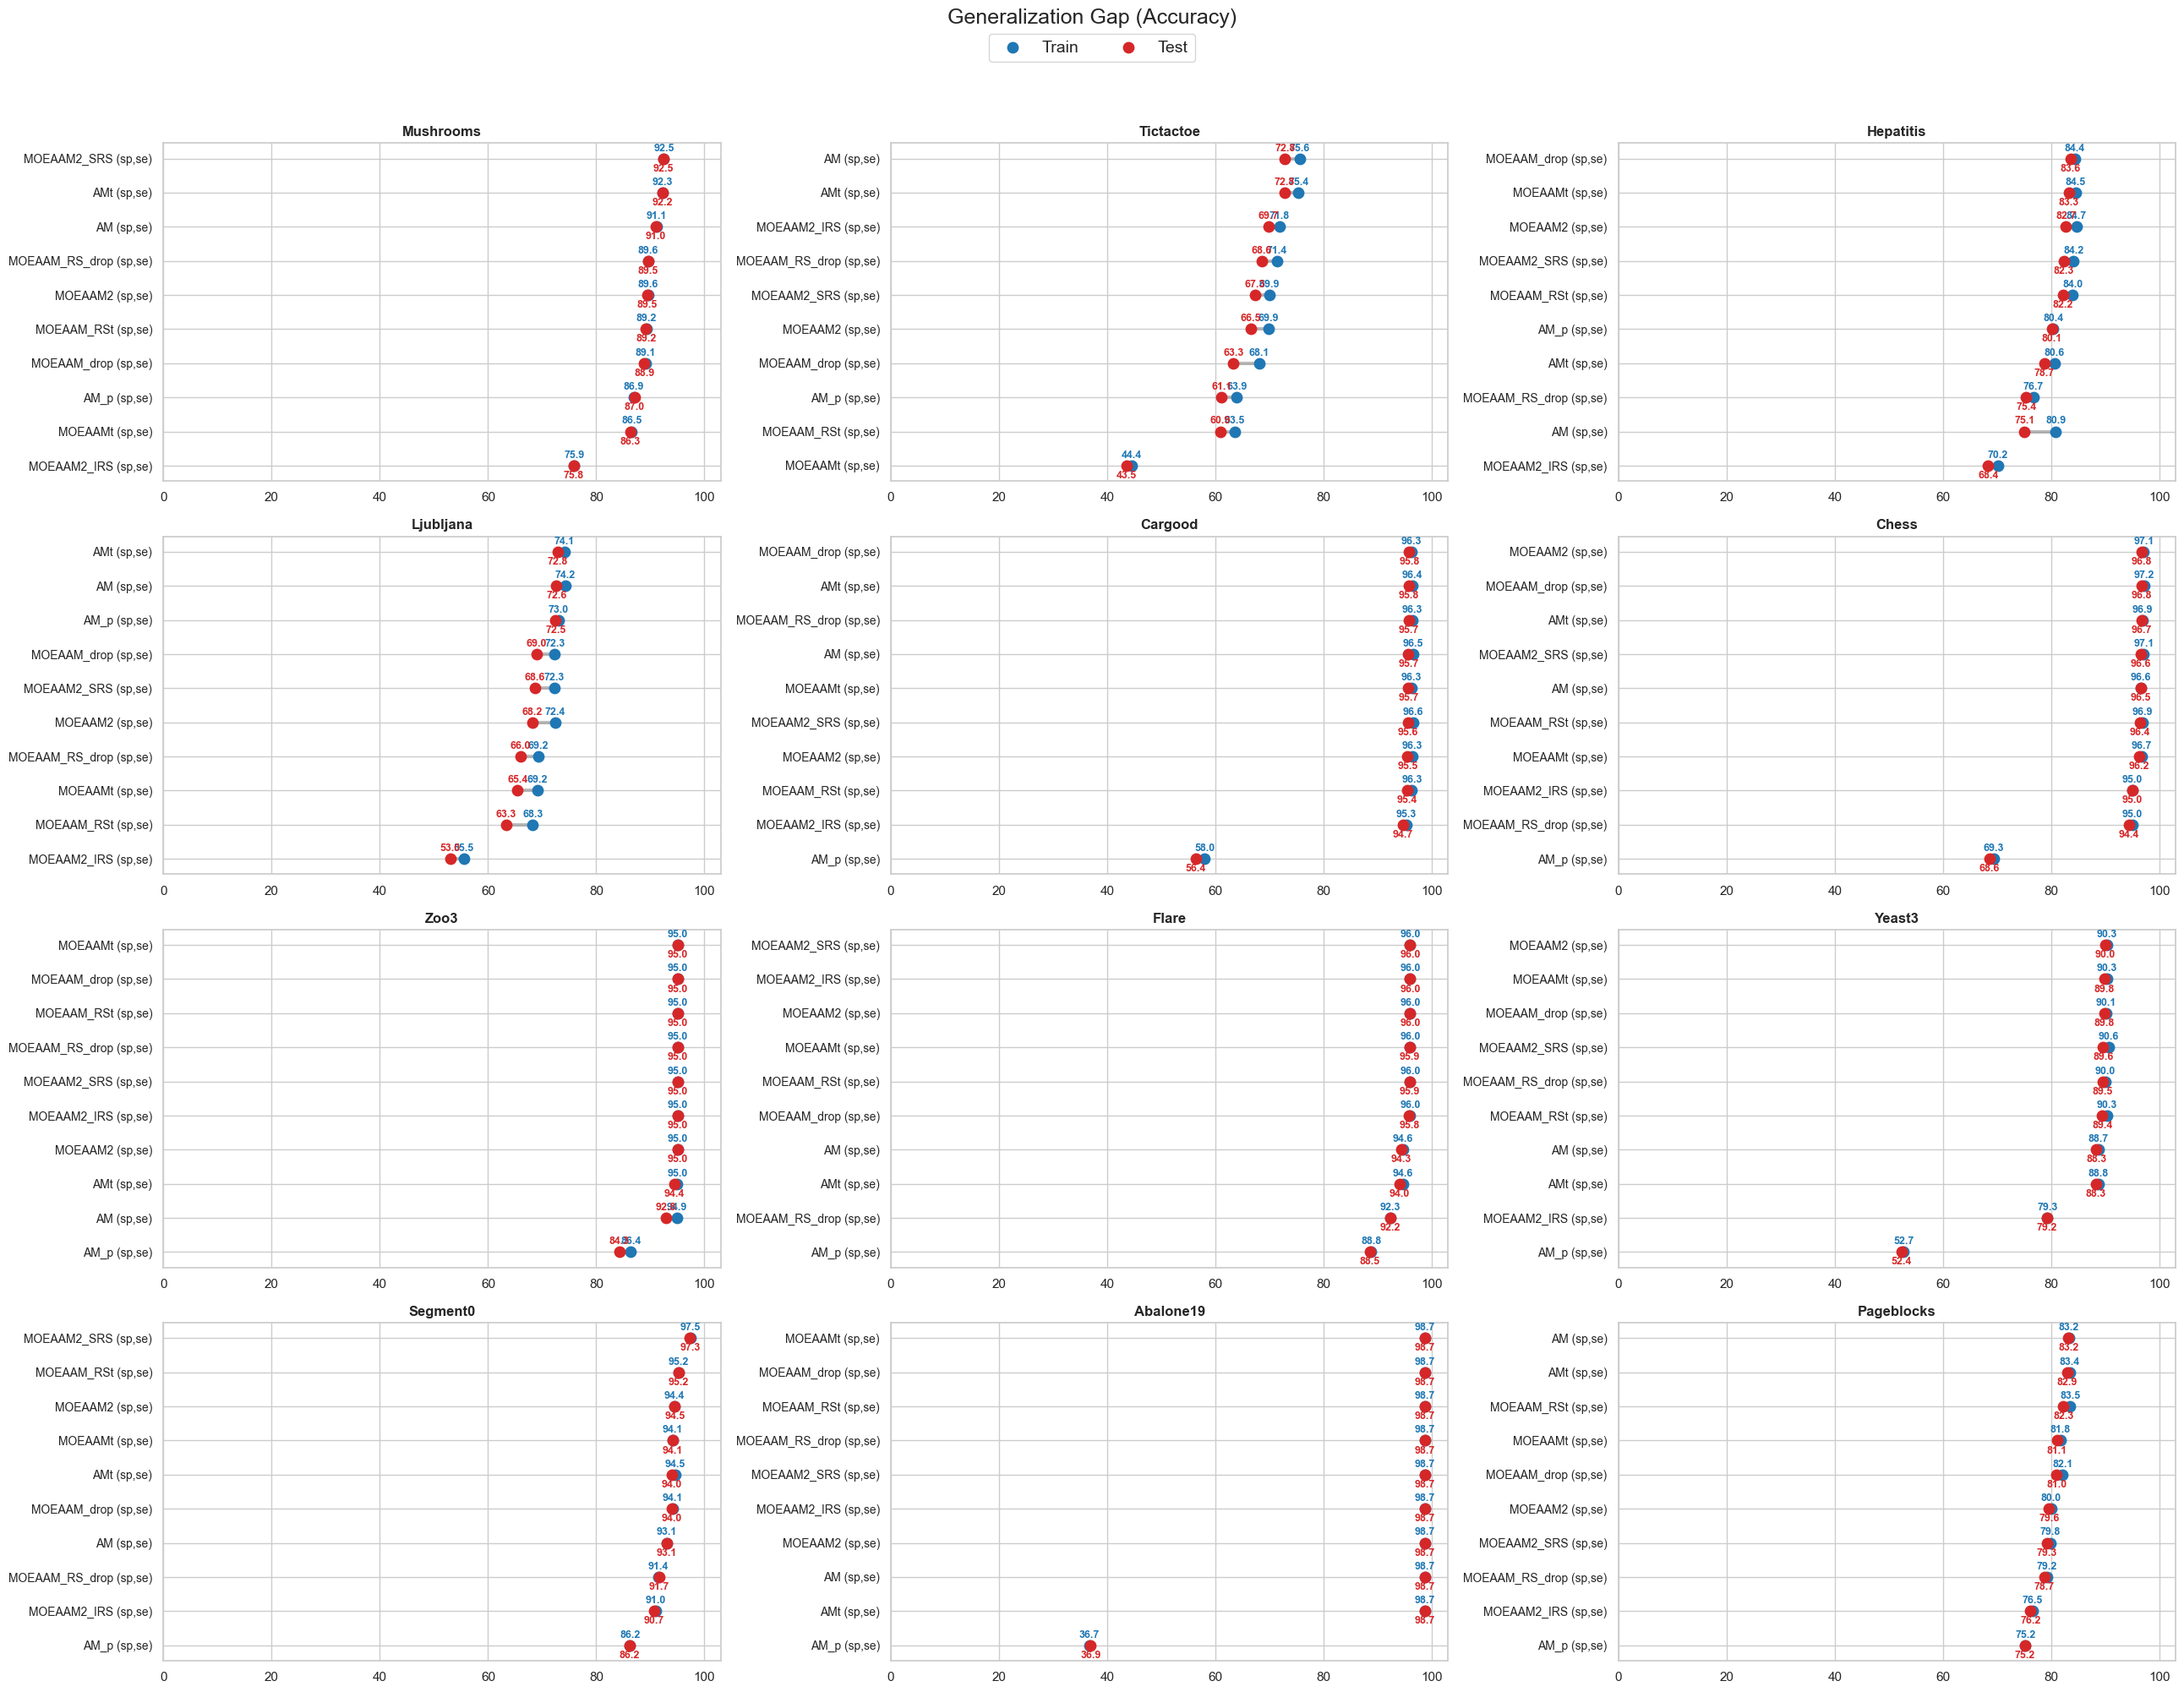

In [6]:
plot_generalization_gap(dfs, DATASETS, metric="accuracy")

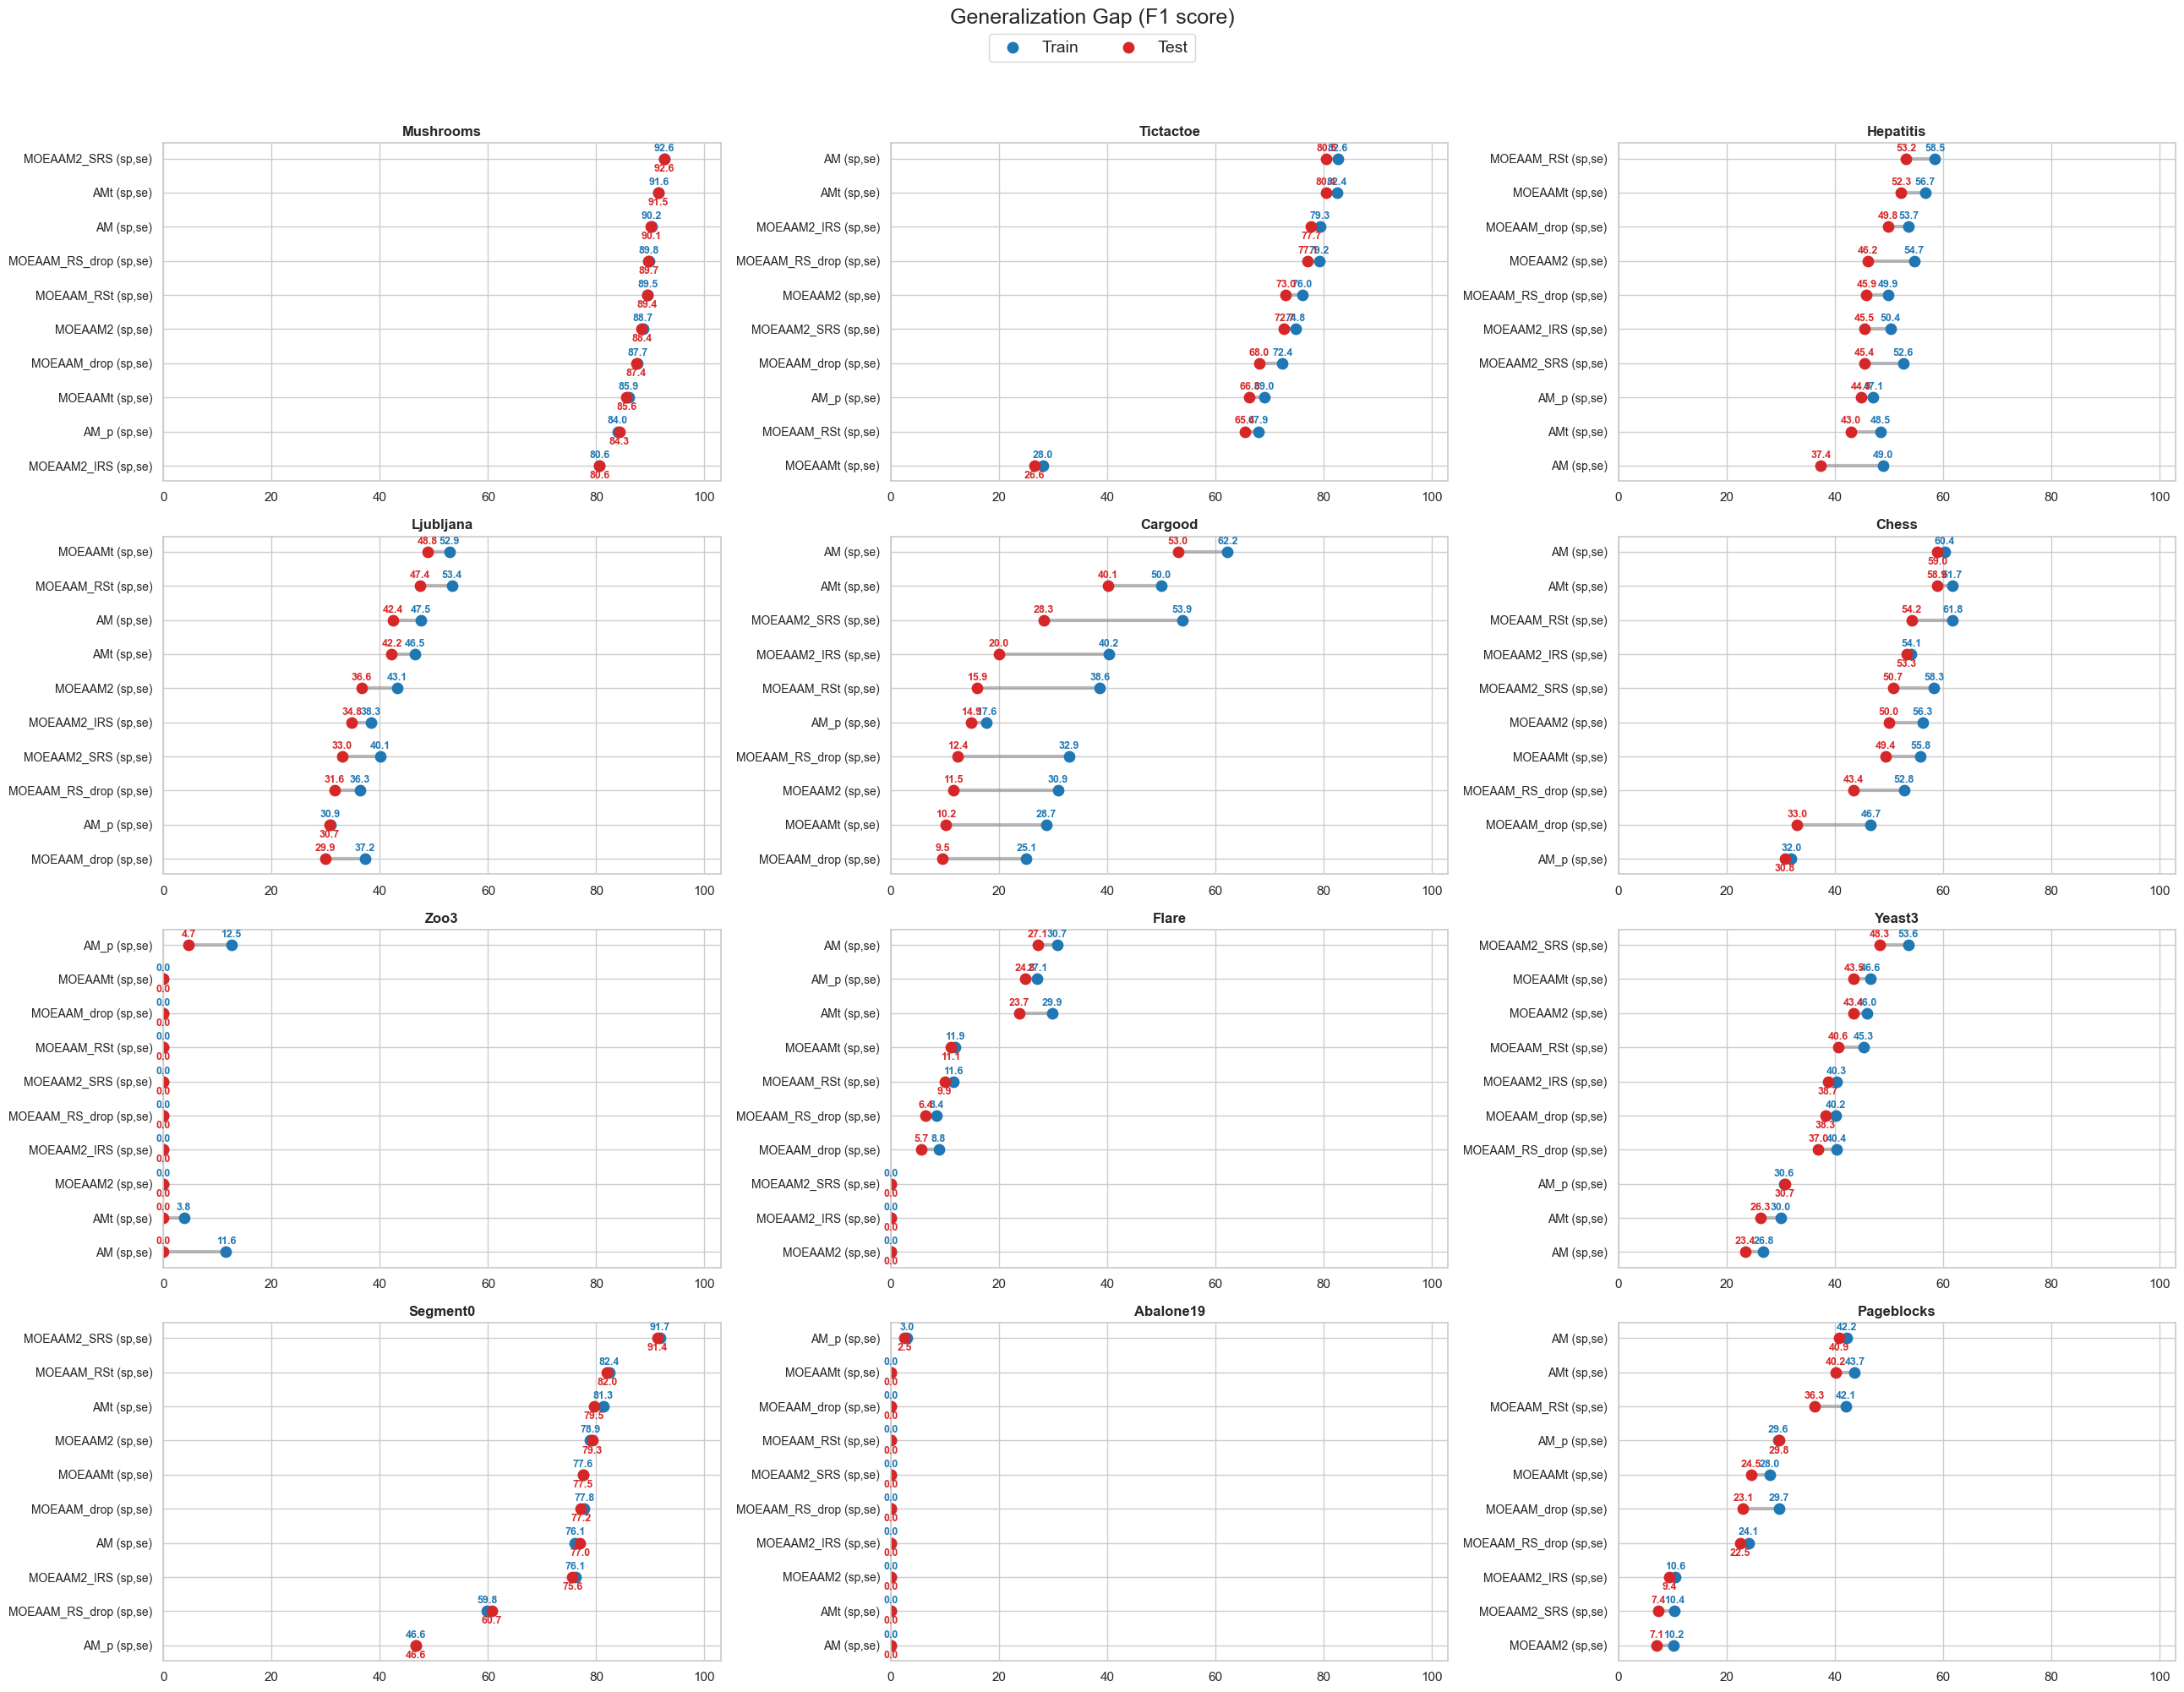

In [7]:
plot_generalization_gap(dfs, DATASETS, metric="f1_score")

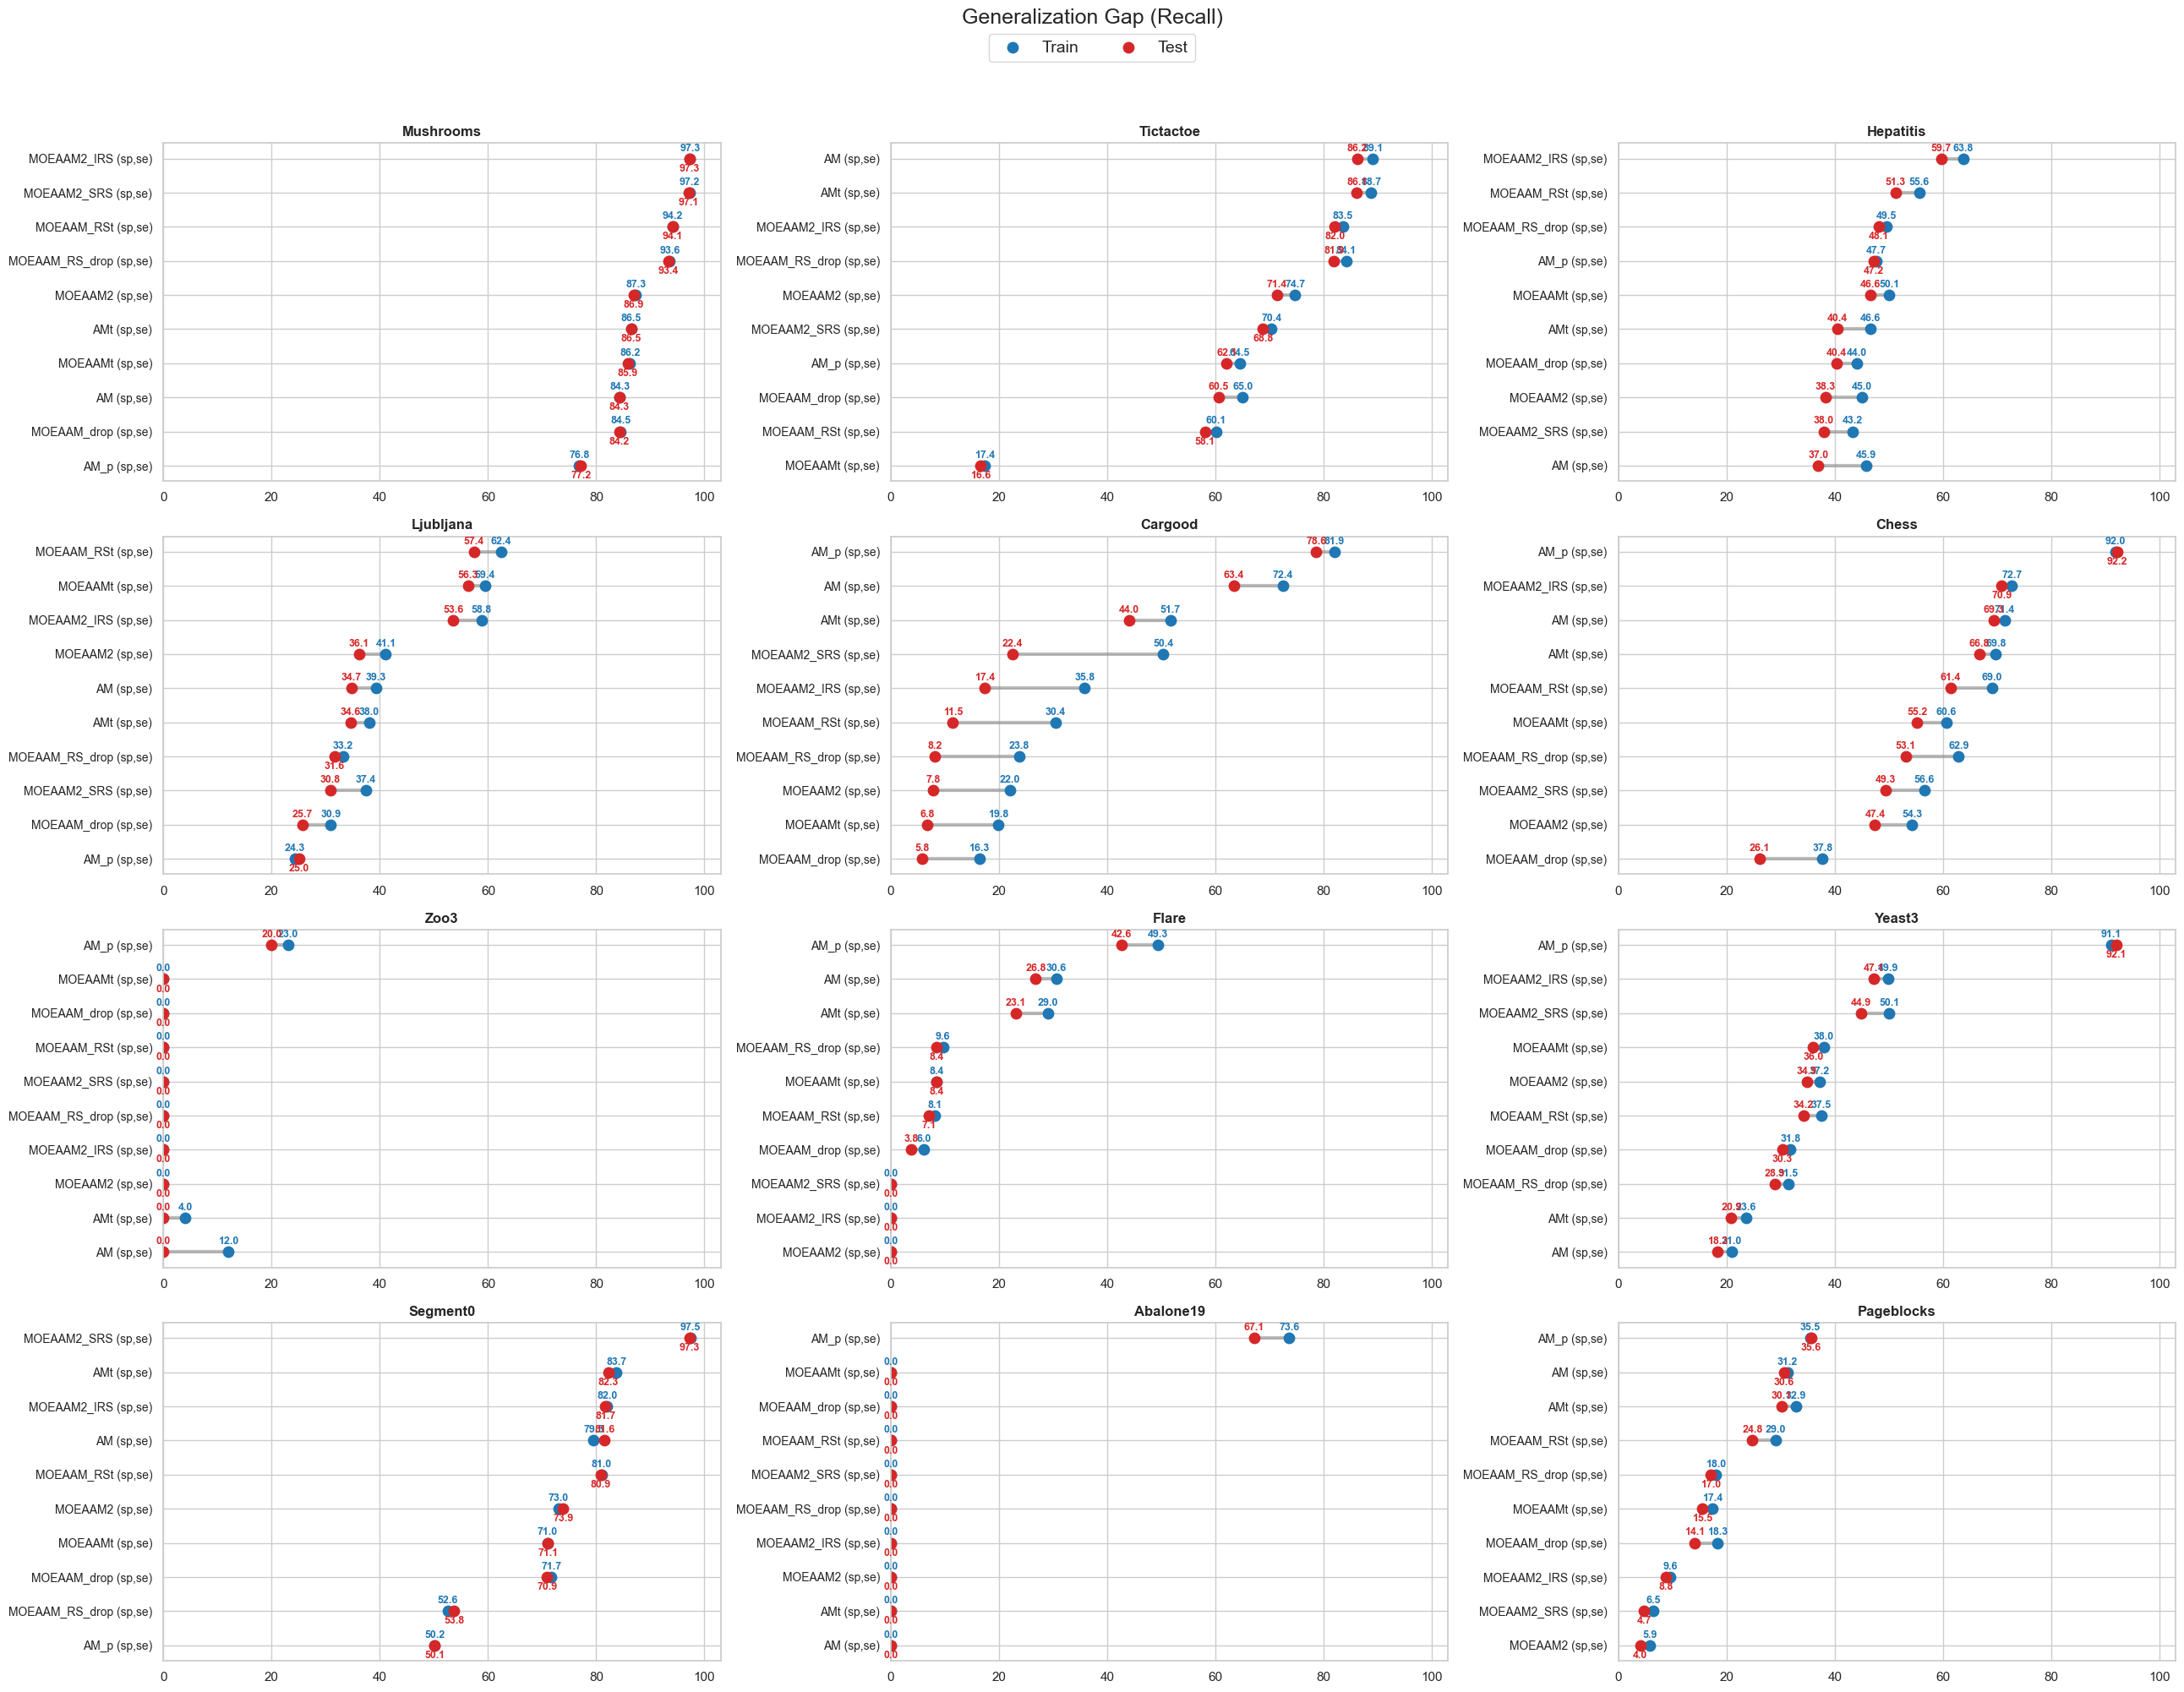

In [8]:
plot_generalization_gap(dfs, DATASETS, metric="recall")

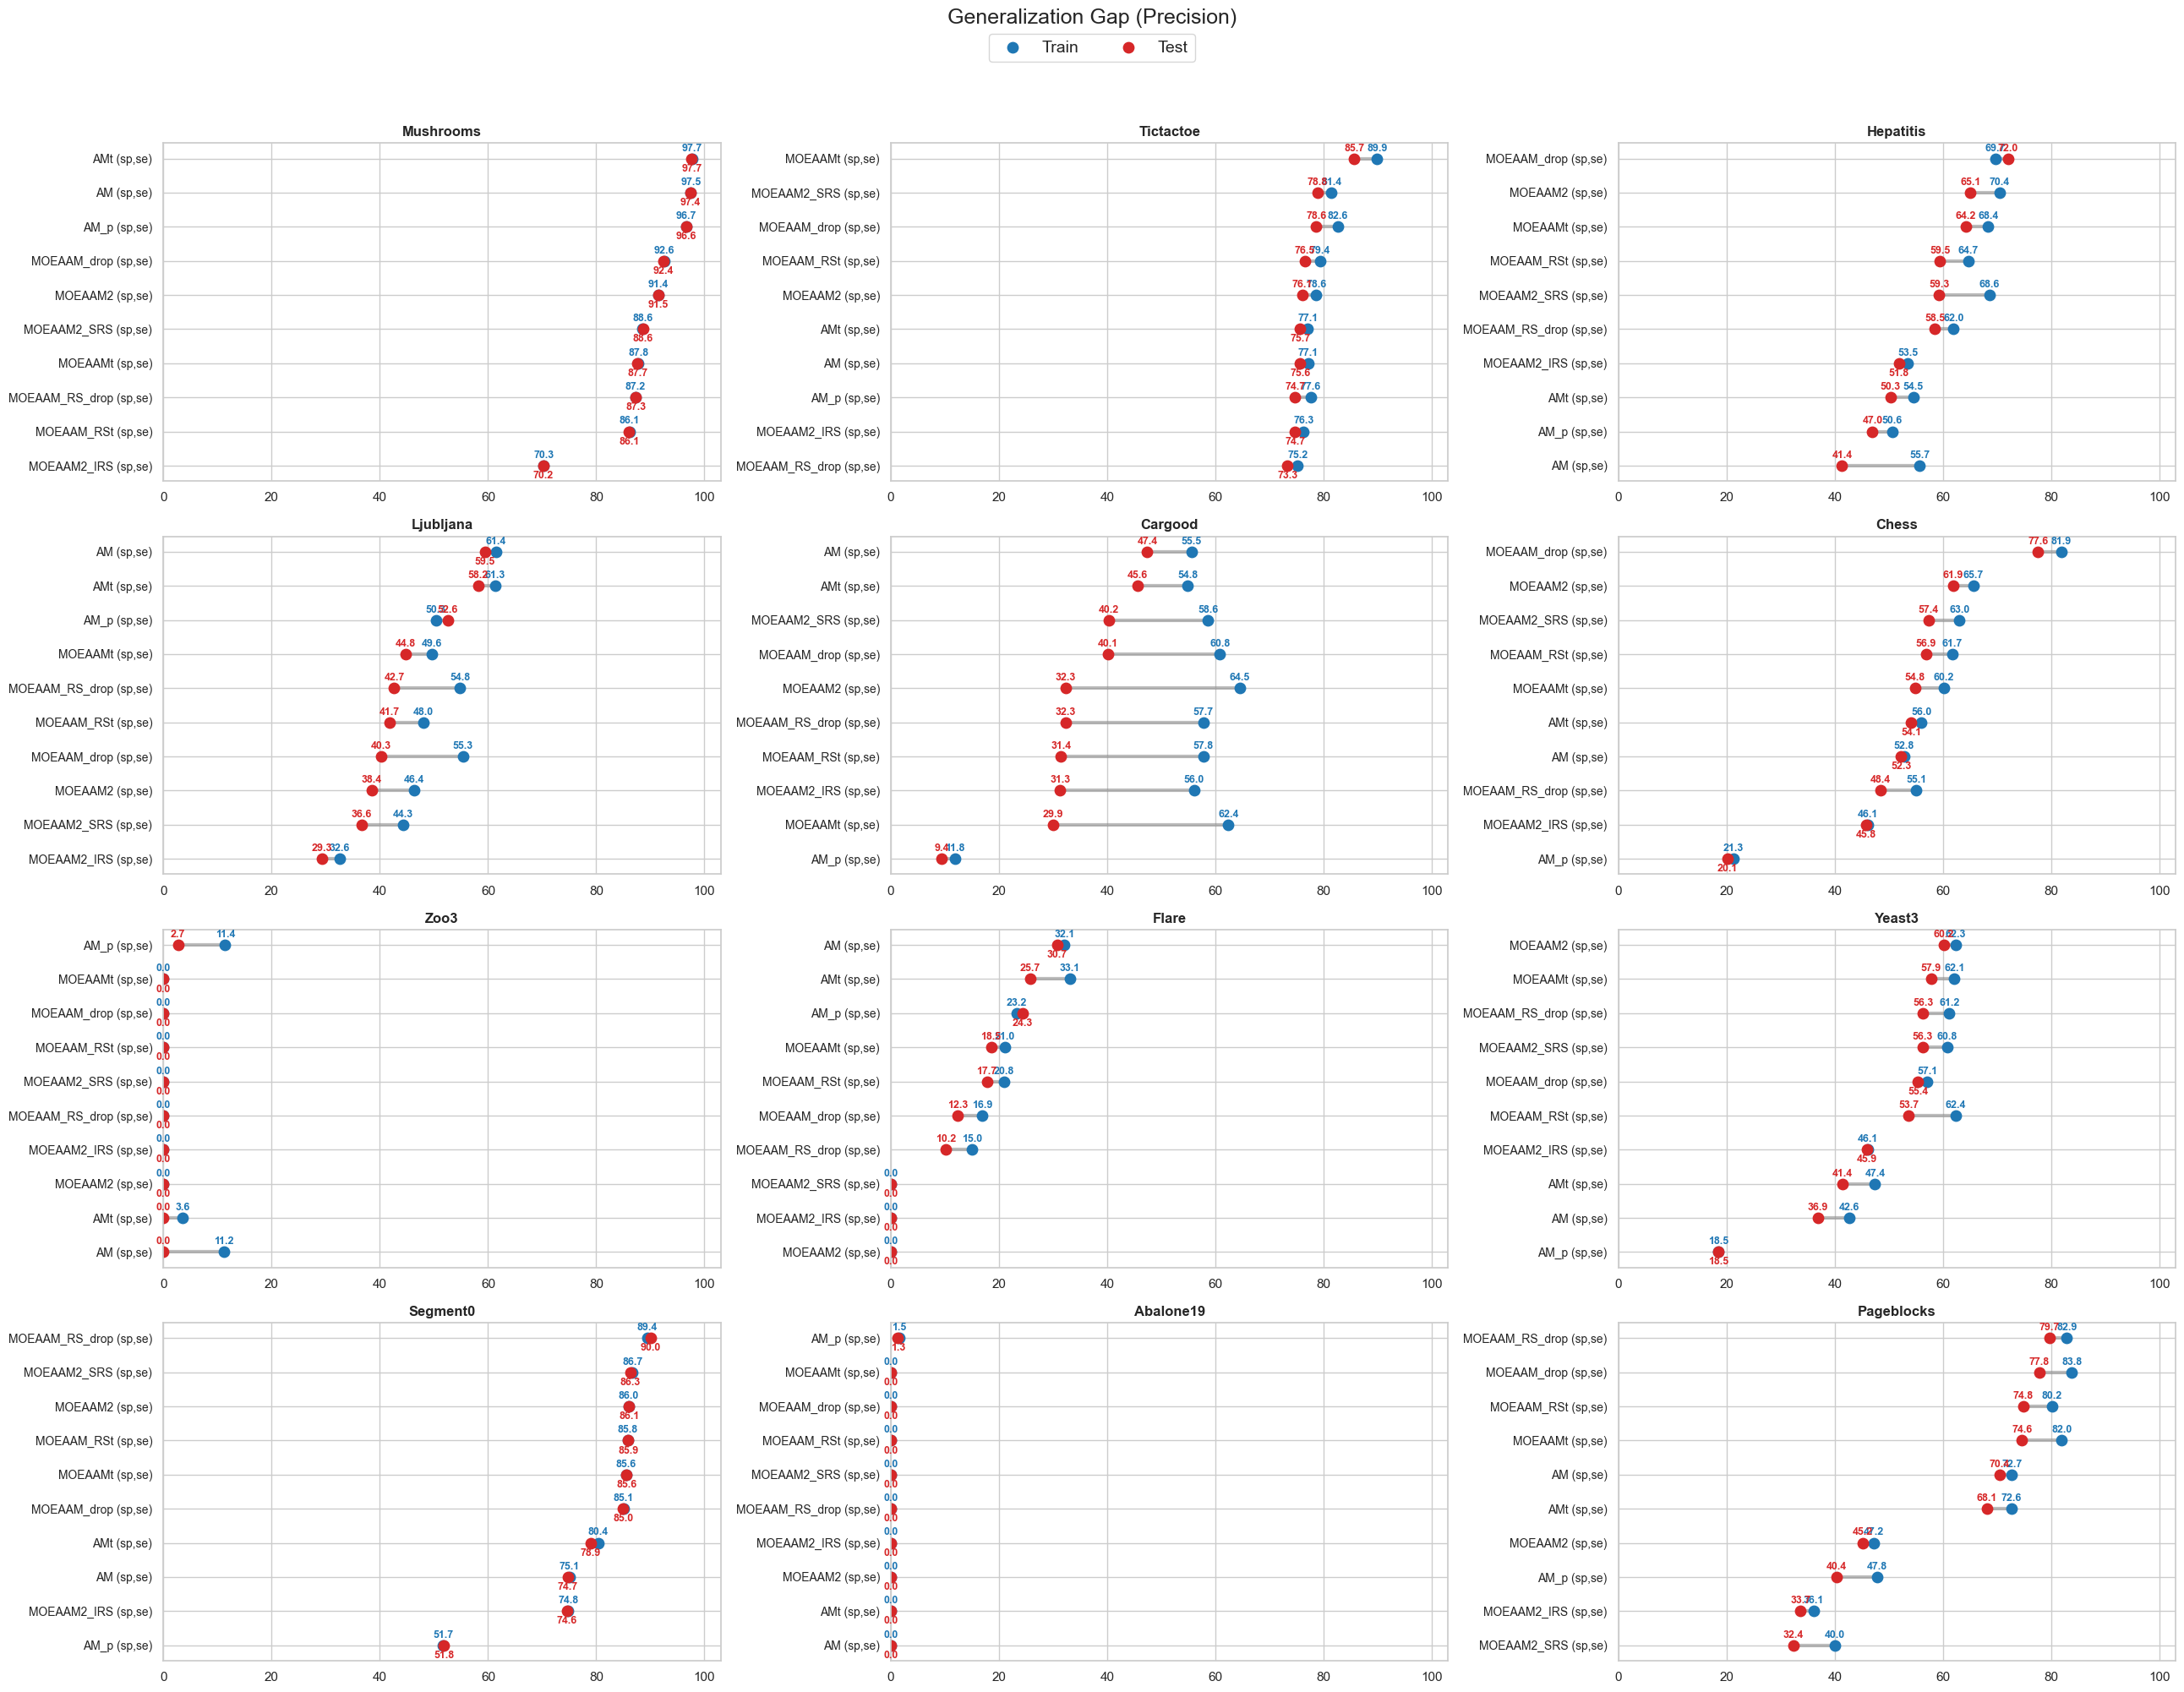

In [9]:
plot_generalization_gap(dfs, DATASETS, metric="precision")

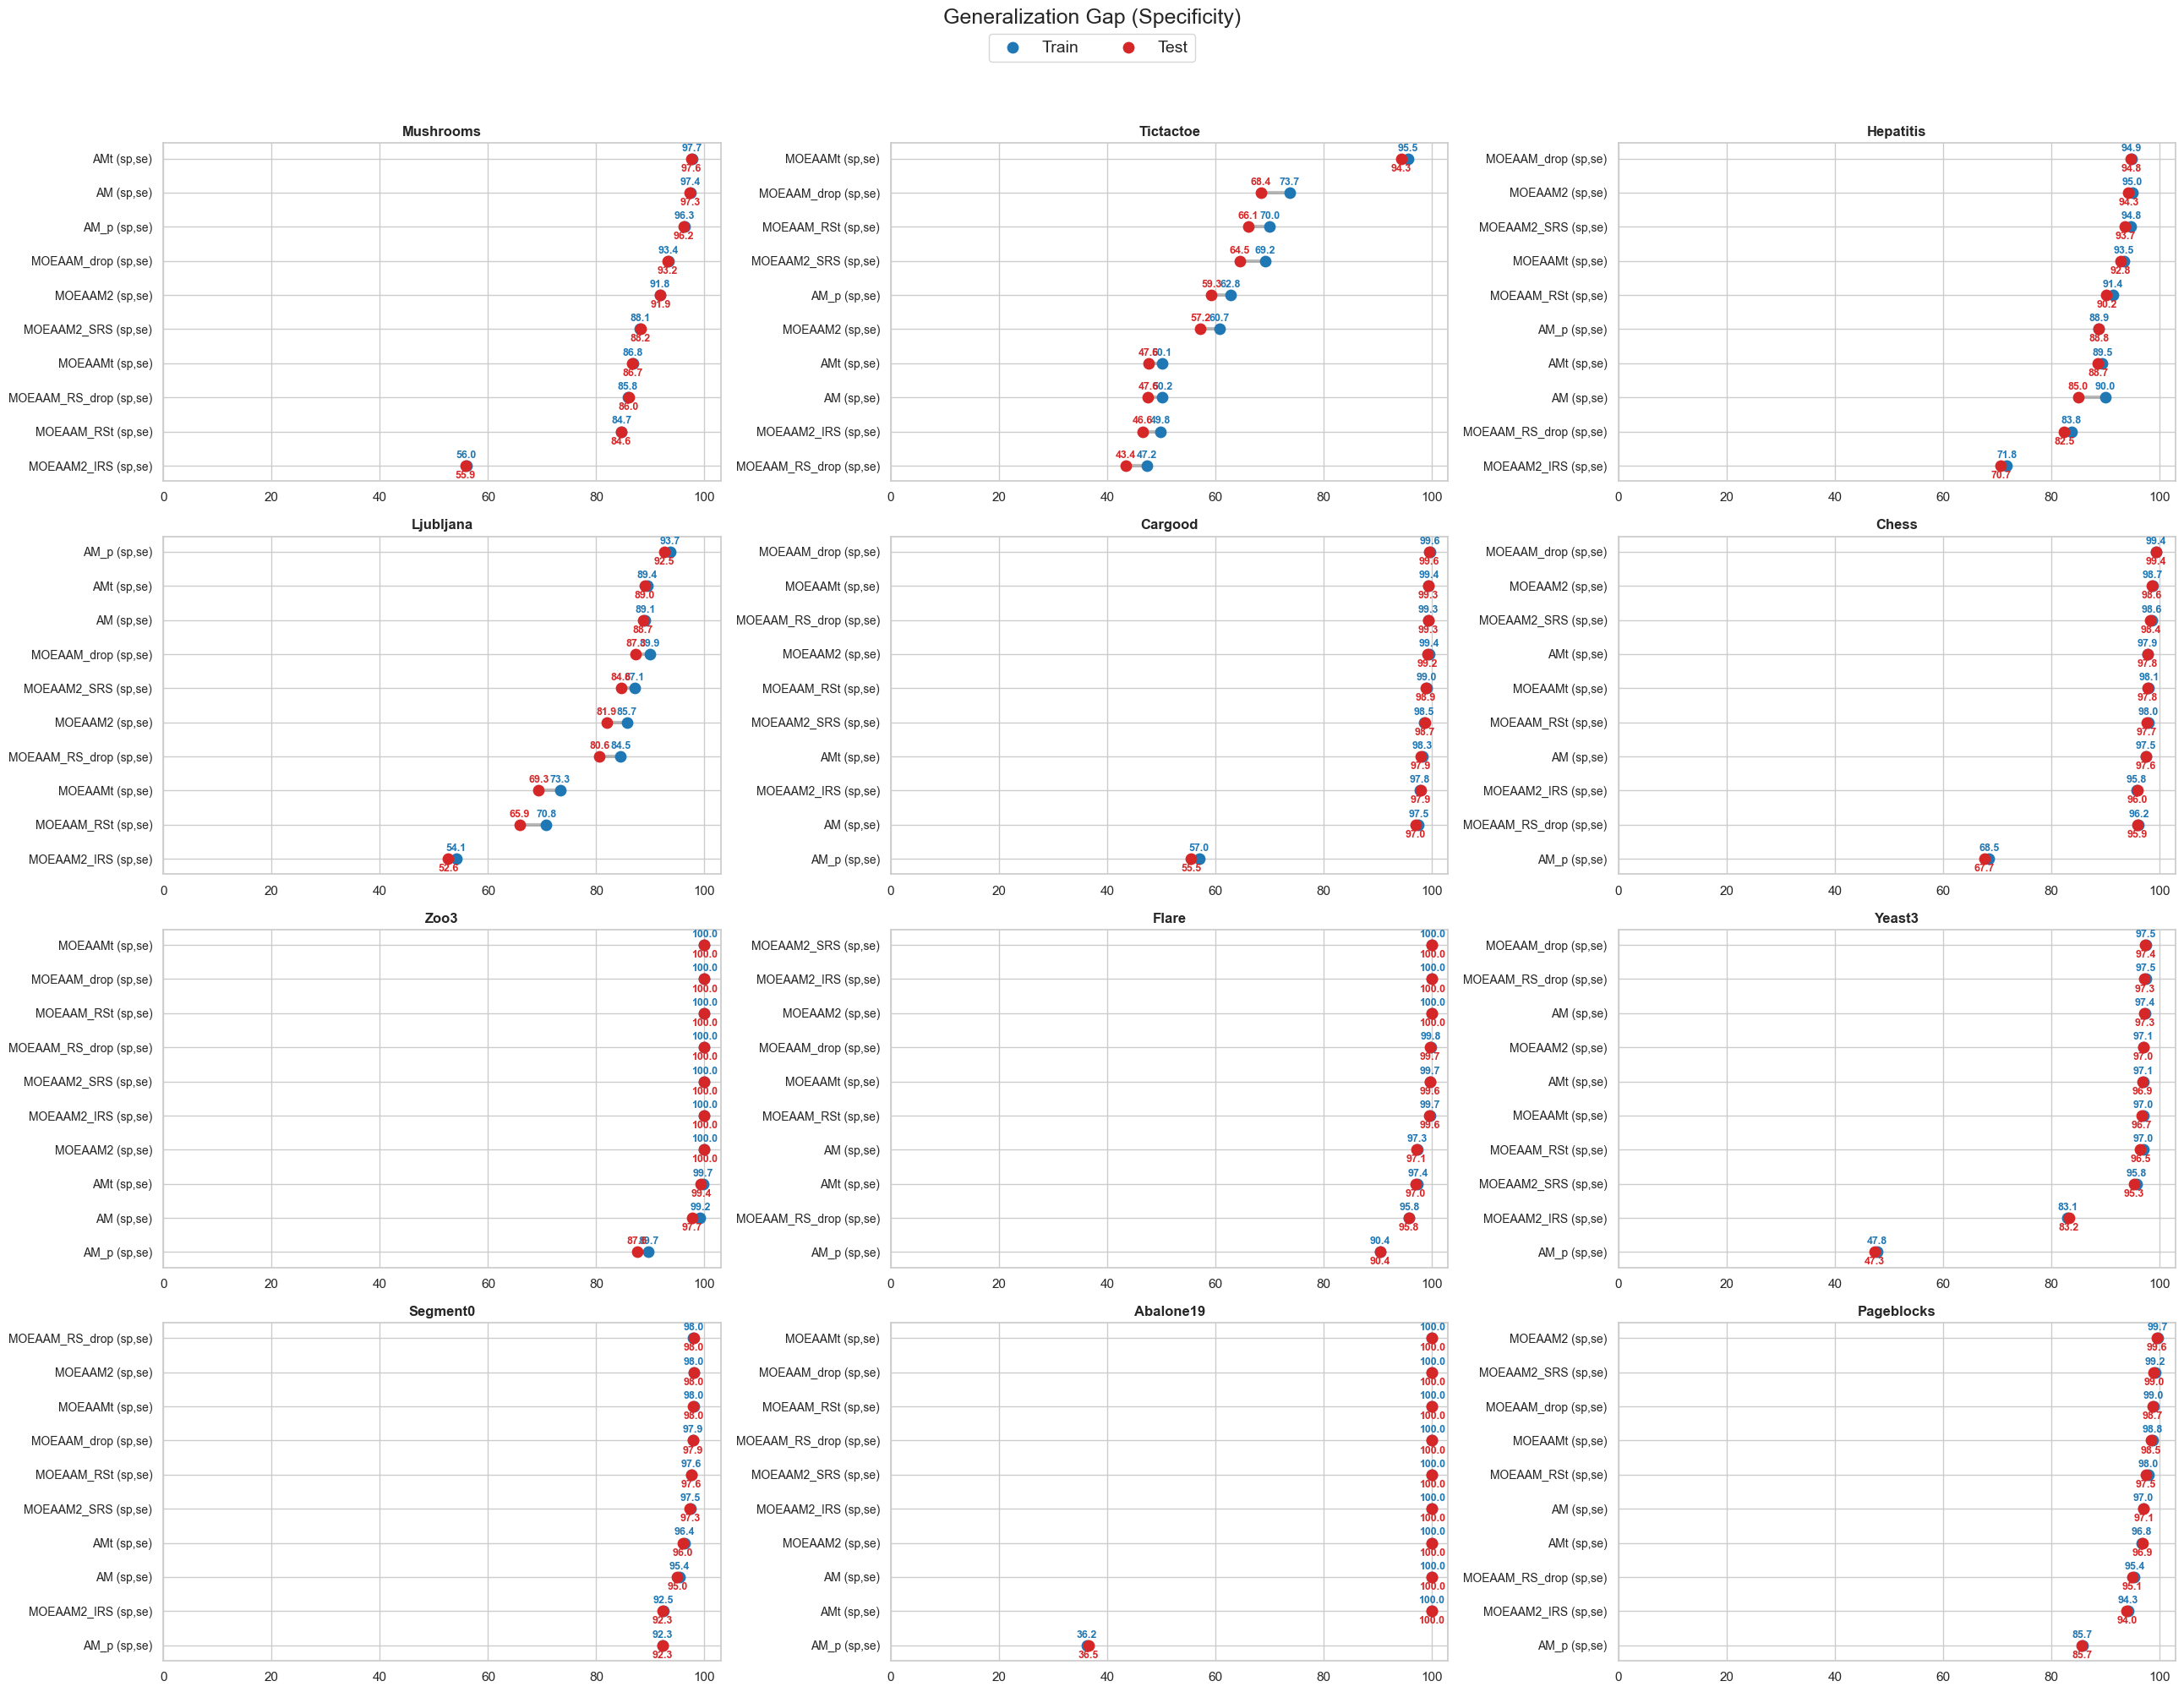

In [10]:
plot_generalization_gap(dfs, DATASETS, metric="specificity")

##### Results Ranking

In [11]:
def get_ranking_df(df_values):

    df_ranks = df_values.rank(axis=1, ascending=False, method='average')
    avg_ranks = df_ranks.mean(axis=0)
    df_ranks.loc['Average Rank'] = avg_ranks
    df_ranks= df_ranks.map(lambda x: f'{x:g}')
    
    return df_ranks

def get_ranking(df_values):
    ranks = df_values.rank(axis=1, ascending=False, method='average')
    df_out = df_values.map('{:g}'.format) + " (" + ranks.map('{:g}'.format) + ")"
    df_out.loc['Average Rank'] = ranks.mean().map('{:.4g}'.format)

    return df_out, ranks.mean()

def plot_avg_ranks(avg_ranks, metric_name):
    sorted_avg_ranks = avg_ranks.sort_values()
    plt.figure(figsize=(12, 6))
    sorted_avg_ranks.plot(kind='barh', color='lightgrey')
    plt.title(f'Average Rank of Each Variant for {metric_name}')
    plt.xlabel('Mean Rank')
    
    plt.axvline(x=sorted_avg_ranks.mean(), color='red', linestyle='--', label='Global Average')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def extract_means(results_data, folders=FOLDERS, target_metric="accuracy"):
    friedman_dict = {}

    for folder in folders:
        for obj in OBJECTIVES:
            
            dict_key = f"{folder}({obj})"    
            scores_list = []
            
            for dataset in DATASETS:
                if dataset not in results_data or 'mean' not in results_data[dataset]:
                    scores_list.append(None)
                    continue
                
                df_mean = results_data[dataset]['mean']
                
                if df_mean.empty:
                    scores_list.append(None)
                    continue
                
                try:
                    val = df_mean.loc[(folder, obj, 'test'), target_metric]
                    scores_list.append(round(val, 2))
                    
                except KeyError:
                    scores_list.append(None)
            
            friedman_dict[dict_key] = scores_list

    return friedman_dict

def extract_specific_means(results_data, combinations, target_metric="accuracy"):
    friedman_dict = {}

    for algo, obj in combinations:
        
        dict_key = f"{algo}({obj})"
        scores_list = []
        
        for dataset in DATASETS:
            if dataset not in results_data or 'mean' not in results_data[dataset]:
                scores_list.append(None)
                continue
            
            df_mean = results_data[dataset]['mean']
            
            if df_mean.empty:
                scores_list.append(None)
                continue
            
            try:
                val = df_mean.loc[(algo, obj, 'test'), target_metric]
                scores_list.append(round(val, 2))
                
            except KeyError:
                scores_list.append(None)
        
        friedman_dict[dict_key] = scores_list

    return friedman_dict

1. ACCURACY

In [13]:
accuracy_dict = extract_means(dfs, target_metric="accuracy")

accuracy_df = pd.DataFrame(accuracy_dict, index=DATASETS)
accuracy_ranks, accuracy_avg_ranks = get_ranking(accuracy_df)
accuracy_ranks

,AM(spec_sens),AMt(spec_sens),AM_p(spec_sens),MOEAAMt(spec_sens),MOEAAM_RSt(spec_sens),MOEAAM_drop(spec_sens),MOEAAM_RS_drop(spec_sens),MOEAAM2(spec_sens),MOEAAM2_IRS(spec_sens),MOEAAM2_SRS(spec_sens)
mushrooms,91.03 (3),92.22 (2),87.05 (8),86.29 (9),89.18 (6),88.9 (7),89.55 (4),89.47 (5),75.84 (10),92.46 (1)
tictactoe,72.82 (1),72.78 (2),61.1 (8),43.53 (10),60.85 (9),63.28 (7),68.56 (4),66.49 (6),69.75 (3),67.29 (5)
hepatitis,75.1 (9),78.71 (7),80.13 (6),83.29 (2),82.19 (5),83.61 (1),75.36 (8),82.71 (3),68.39 (10),82.32 (4)
ljubljana,72.64 (2),72.83 (1),72.5 (3),65.44 (8),63.31 (9),68.97 (4),66.04 (7),68.23 (6),53.02 (10),68.62 (5)
cargood,95.66 (4),95.75 (2),56.39 (10),95.65 (5),95.39 (8),95.81 (1),95.68 (3),95.52 (7),94.66 (9),95.61 (6)
chess,96.53 (5),96.67 (3),68.56 (10),96.24 (7),96.38 (6),96.77 (2),94.37 (9),96.79 (1),95.04 (8),96.62 (4)
zoo3,92.85 (9),94.45 (8),84.26 (10),95.05 (4),95.05 (4),95.05 (4),95.05 (4),95.05 (4),95.05 (4),95.05 (4)
flare,94.32 (7),94.02 (8),88.51 (10),95.95 (4),95.85 (5),95.82 (6),92.25 (9),95.97 (2),95.97 (2),95.97 (2)
yeast3,88.33 (7),88.3 (8),52.37 (10),89.85 (2.5),89.44 (6),89.85 (2.5),89.55 (5),90.01 (1),79.18 (9),89.62 (4)
segment0,93.06 (7),94.03 (5),86.2 (10),94.1 (4),95.2 (2),93.98 (6),91.66 (8),94.52 (3),90.75 (9),97.32 (1)


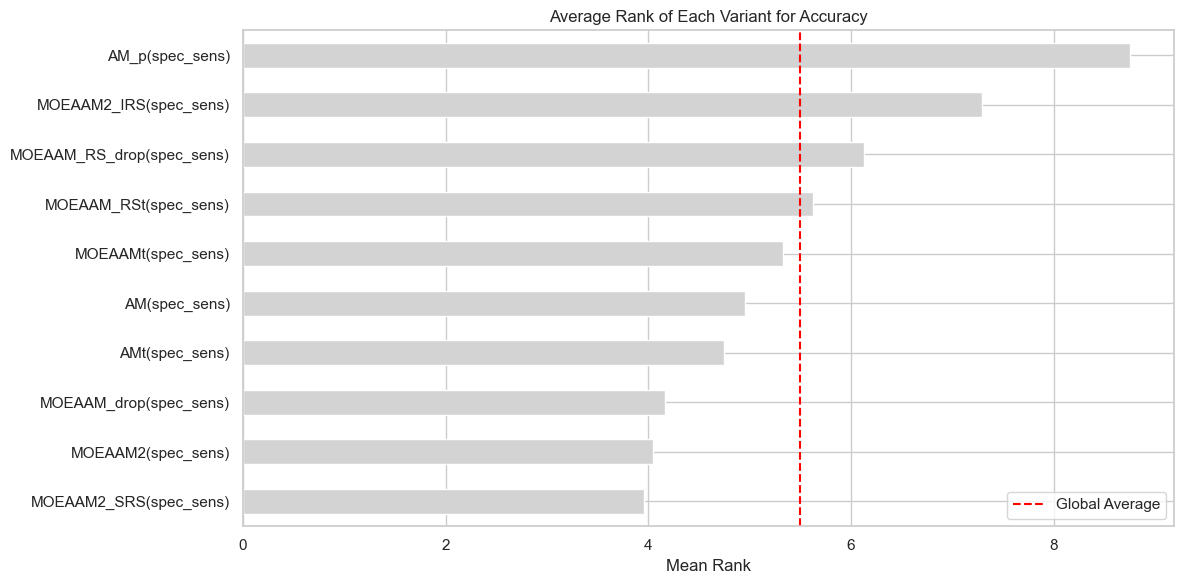

In [14]:
plot_avg_ranks(accuracy_avg_ranks, "Accuracy")

2. F1-SCORE

In [15]:
f1_dict = extract_means(dfs, target_metric="f1_score")

f1_df = pd.DataFrame(f1_dict, index=DATASETS)
f1_ranks, f1_avg_ranks = get_ranking(f1_df)
f1_ranks

,AM(spec_sens),AMt(spec_sens),AM_p(spec_sens),MOEAAMt(spec_sens),MOEAAM_RSt(spec_sens),MOEAAM_drop(spec_sens),MOEAAM_RS_drop(spec_sens),MOEAAM2(spec_sens),MOEAAM2_IRS(spec_sens),MOEAAM2_SRS(spec_sens)
mushrooms,90.15 (3),91.5 (2),84.3 (9),85.62 (8),89.44 (5),87.42 (7),89.67 (4),88.42 (6),80.58 (10),92.56 (1)
tictactoe,80.46 (1),80.43 (2),66.27 (8),26.56 (10),65.43 (9),68.03 (7),77.08 (4),72.98 (5),77.71 (3),72.69 (6)
hepatitis,37.45 (10),42.96 (9),44.92 (8),52.3 (2),53.2 (1),49.83 (3),45.87 (5),46.16 (4),45.48 (6),45.44 (7)
ljubljana,42.39 (3),42.19 (4),30.68 (9),48.77 (1),47.38 (2),29.93 (10),31.58 (8),36.64 (5),34.83 (6),33.03 (7)
cargood,53.03 (1),40.15 (2),14.88 (6),10.19 (9),15.93 (5),9.54 (10),12.38 (7),11.5 (8),20 (4),28.28 (3)
chess,58.98 (1),58.92 (2),30.76 (10),49.38 (7),54.22 (3),33.05 (9),43.39 (8),49.98 (6),53.26 (4),50.74 (5)
zoo3,0 (6),0 (6),4.67 (1),0 (6),0 (6),0 (6),0 (6),0 (6),0 (6),0 (6)
flare,27.11 (1),23.7 (3),24.78 (2),11.07 (4),9.92 (5),5.67 (7),6.38 (6),0 (9),0 (9),0 (9)
yeast3,23.41 (10),26.33 (9),30.74 (8),43.54 (2),40.62 (4),38.27 (6),36.96 (7),43.41 (3),38.71 (5),48.27 (1)
segment0,77 (7),79.54 (3),46.62 (10),77.55 (5),82 (2),77.17 (6),60.68 (9),79.29 (4),75.62 (8),91.37 (1)


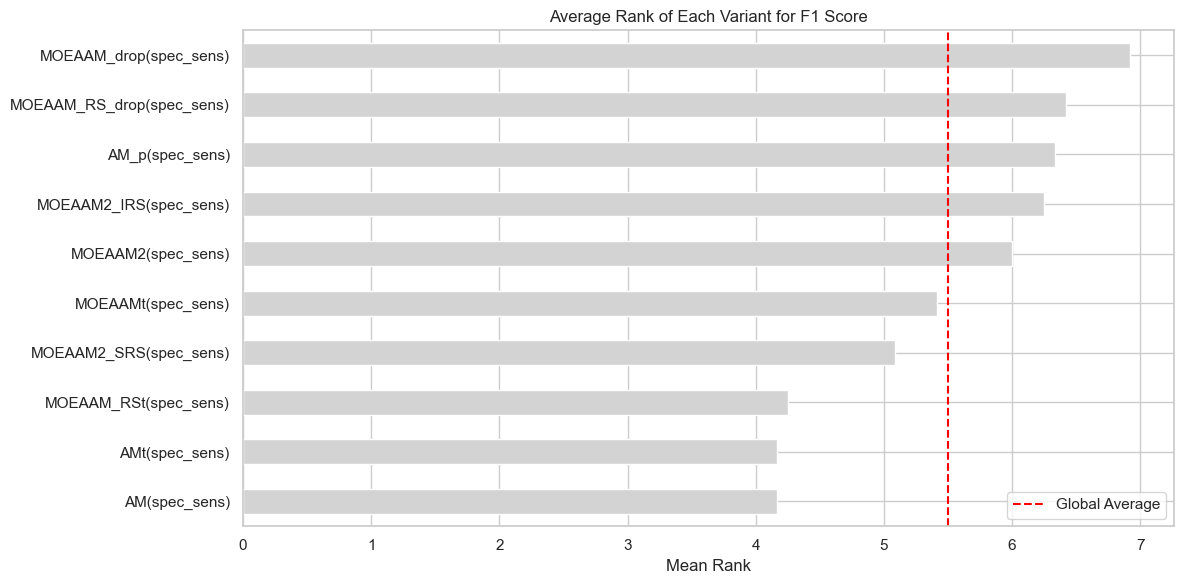

In [16]:
plot_avg_ranks(f1_avg_ranks, "F1 Score")

3. RECALL

In [17]:
recall_dict = extract_means(dfs, target_metric="recall")

recall_df = pd.DataFrame(recall_dict, index=DATASETS)
recall_ranks, recall_avg_ranks = get_ranking(recall_df)
recall_ranks

,AM(spec_sens),AMt(spec_sens),AM_p(spec_sens),MOEAAMt(spec_sens),MOEAAM_RSt(spec_sens),MOEAAM_drop(spec_sens),MOEAAM_RS_drop(spec_sens),MOEAAM2(spec_sens),MOEAAM2_IRS(spec_sens),MOEAAM2_SRS(spec_sens)
mushrooms,84.28 (8),86.46 (6),77.19 (10),85.86 (7),94.09 (3),84.25 (9),93.4 (4),86.91 (5),97.3 (1),97.07 (2)
tictactoe,86.23 (1),86.12 (2),62.08 (7),16.6 (10),58.09 (9),60.55 (8),81.9 (4),71.39 (5),82.04 (3),68.76 (6)
hepatitis,36.95 (10),40.43 (6),47.24 (4),46.57 (5),51.29 (2),40.38 (7),48.1 (3),38.29 (8),59.71 (1),38 (9)
ljubljana,34.72 (5),34.59 (6),25.04 (10),56.35 (2),57.43 (1),25.66 (9),31.6 (7),36.12 (4),53.59 (3),30.81 (8)
cargood,63.41 (2),44.03 (3),78.64 (1),6.76 (9),11.46 (6),5.78 (10),8.15 (7),7.8 (8),17.39 (5),22.44 (4)
chess,69.33 (3),66.76 (4),92.19 (1),55.24 (6),61.43 (5),26.1 (10),53.14 (7),47.43 (9),70.86 (2),49.33 (8)
zoo3,0 (6),0 (6),20 (1),0 (6),0 (6),0 (6),0 (6),0 (6),0 (6),0 (6)
flare,26.78 (2),23.11 (3),42.61 (1),8.42 (5),7.08 (6),3.78 (7),8.44 (4),0 (9),0 (9),0 (9)
yeast3,18.32 (10),20.88 (9),92.06 (1),36.04 (4),34.22 (6),30.31 (7),28.95 (8),34.9 (5),47.15 (2),44.91 (3)
segment0,81.56 (4),82.26 (2),50.12 (10),71.08 (7),80.86 (5),70.92 (8),53.75 (9),73.88 (6),81.68 (3),97.29 (1)


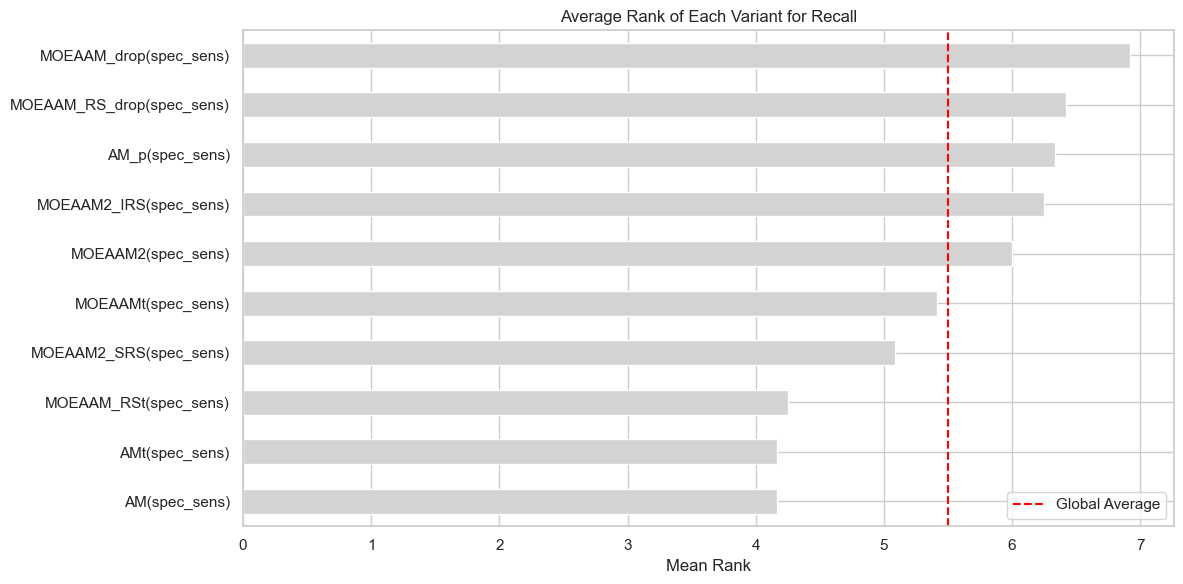

In [18]:
plot_avg_ranks(f1_avg_ranks, "Recall")

4. PRECISION

In [19]:
precision_dict = extract_means(dfs, target_metric="precision")

precision_df = pd.DataFrame(precision_dict, index=DATASETS)
precision_ranks, precision_avg_ranks = get_ranking(precision_df)
precision_ranks

,AM(spec_sens),AMt(spec_sens),AM_p(spec_sens),MOEAAMt(spec_sens),MOEAAM_RSt(spec_sens),MOEAAM_drop(spec_sens),MOEAAM_RS_drop(spec_sens),MOEAAM2(spec_sens),MOEAAM2_IRS(spec_sens),MOEAAM2_SRS(spec_sens)
mushrooms,97.4 (2),97.66 (1),96.59 (3),87.65 (7),86.09 (9),92.4 (4),87.32 (8),91.47 (5),70.2 (10),88.63 (6)
tictactoe,75.64 (7),75.66 (6),74.74 (8),85.67 (1),76.54 (4),78.61 (3),73.27 (10),76.07 (5),74.71 (9),78.82 (2)
hepatitis,41.35 (10),50.28 (8),46.97 (9),64.19 (3),59.46 (4),72 (1),58.49 (6),65.07 (2),51.85 (7),59.28 (5)
ljubljana,59.48 (1),58.18 (2),52.61 (3),44.76 (4),41.74 (6),40.29 (7),42.66 (5),38.45 (8),29.3 (10),36.61 (9)
cargood,47.39 (1),45.65 (2),9.38 (10),29.92 (9),31.41 (7),40.13 (4),32.27 (6),32.33 (5),31.26 (8),40.22 (3)
chess,52.28 (7),54.12 (6),20.14 (10),54.82 (5),56.88 (4),77.6 (1),48.42 (8),61.86 (2),45.85 (9),57.35 (3)
zoo3,0 (6),0 (6),2.7 (1),0 (6),0 (6),0 (6),0 (6),0 (6),0 (6),0 (6)
flare,30.74 (1),25.71 (2),24.28 (3),18.5 (4),17.73 (5),12.33 (6),10.15 (7),0 (9),0 (9),0 (9)
yeast3,36.92 (9),41.42 (8),18.52 (10),57.85 (2),53.69 (6),55.42 (5),56.32 (3),60.17 (1),45.94 (7),56.26 (4)
segment0,74.74 (8),78.92 (7),51.84 (10),85.61 (5),85.94 (4),84.97 (6),90.02 (1),86.05 (3),74.6 (9),86.31 (2)


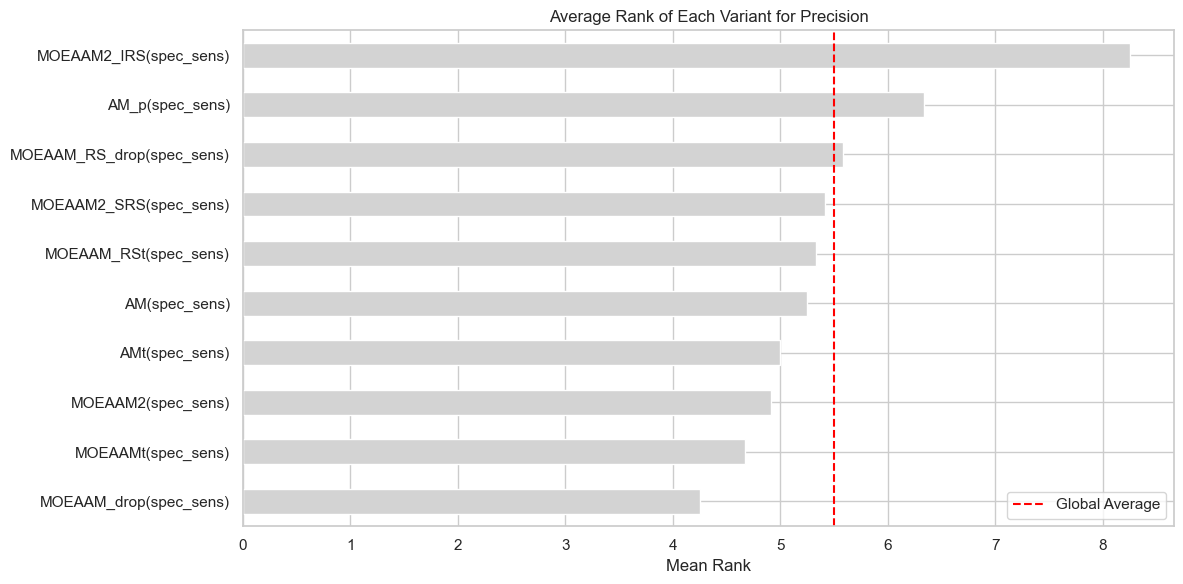

In [20]:
plot_avg_ranks(precision_avg_ranks, "Precision")

5. SPECIFICITY

In [21]:
specificity_dict = extract_means(dfs, target_metric="specificity")

specificity_df = pd.DataFrame(specificity_dict, index=DATASETS)
specificity_ranks, specificity_avg_ranks = get_ranking(specificity_df)
specificity_ranks

,AM(spec_sens),AMt(spec_sens),AM_p(spec_sens),MOEAAMt(spec_sens),MOEAAM_RSt(spec_sens),MOEAAM_drop(spec_sens),MOEAAM_RS_drop(spec_sens),MOEAAM2(spec_sens),MOEAAM2_IRS(spec_sens),MOEAAM2_SRS(spec_sens)
mushrooms,97.32 (2),97.58 (1),96.22 (3),86.69 (7),84.62 (9),93.23 (4),85.96 (8),91.86 (5),55.86 (10),88.18 (6)
tictactoe,47.55 (8),47.63 (7),59.28 (5),94.3 (1),66.1 (3),68.43 (2),43.37 (10),57.22 (6),46.57 (9),64.48 (4)
hepatitis,85.02 (8),88.66 (7),88.82 (6),92.84 (4),90.24 (5),94.78 (1),82.45 (9),94.31 (2),70.69 (10),93.67 (3)
ljubljana,88.66 (3),88.97 (2),92.53 (1),69.33 (8),65.87 (9),87.34 (4),80.63 (7),81.9 (6),52.62 (10),84.62 (5)
cargood,97 (9),97.89 (7),55.48 (10),99.35 (2),98.88 (5),99.55 (1),99.32 (3),99.17 (4),97.88 (8),98.66 (6)
chess,97.55 (7),97.8 (4),67.68 (10),97.78 (5),97.7 (6),99.43 (1),95.92 (9),98.64 (2),95.95 (8),98.39 (3)
zoo3,97.68 (9),99.37 (8),87.59 (10),100 (4),100 (4),100 (4),100 (4),100 (4),100 (4),100 (4)
flare,97.14 (7),97.01 (8),90.42 (10),99.63 (5),99.58 (6),99.69 (4),95.78 (9),100 (2),100 (2),100 (2)
yeast3,97.26 (3),96.9 (5),47.32 (10),96.71 (6),96.49 (7),97.43 (1),97.28 (2),97.04 (4),83.24 (9),95.31 (8)
segment0,94.98 (8),96.01 (7),92.26 (10),97.97 (3),97.61 (5),97.85 (4),98.03 (1),97.98 (2),92.28 (9),97.33 (6)


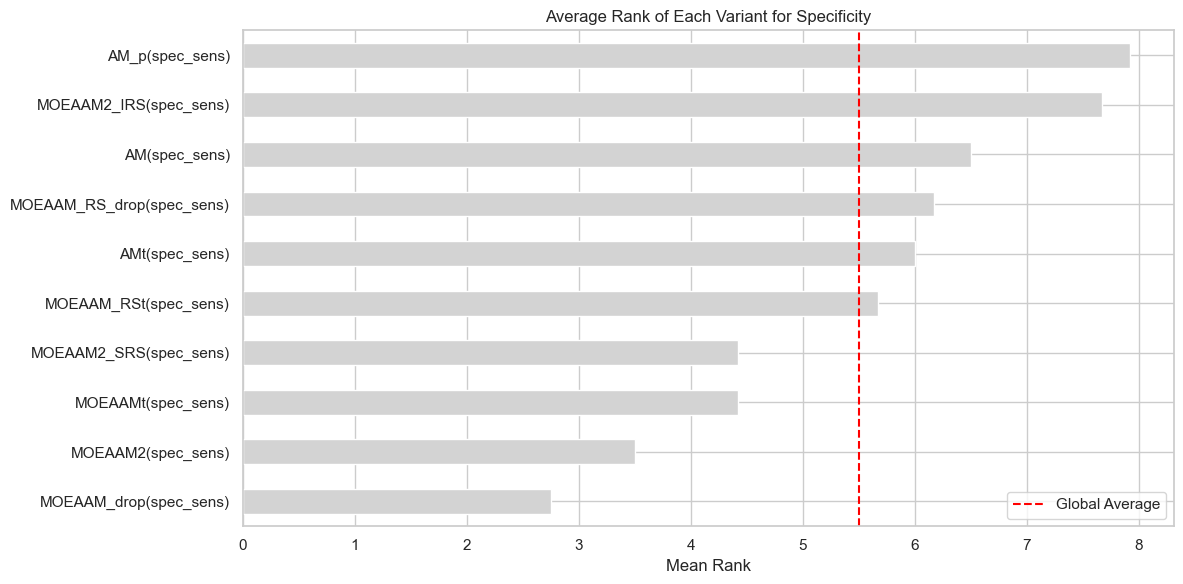

In [22]:
plot_avg_ranks(specificity_avg_ranks, "Specificity")

##### Friedman Tests

In [23]:
data = {
    "Accuracy": accuracy_dict,
    "F1 Score": f1_df,
    "Recall": recall_df,
    "Precision": precision_df,
    "Specificity": specificity_df
}

In [24]:
def friedman_test(data):
    results = []
    
    for metric, data in data.items():
        df = pd.DataFrame(data, index=DATASETS)
        
        stat, p_value = friedmanchisquare(*[df[col] for col in df.columns])
        
        results.append({
            "Metric": metric,
            "Chi-square Stat": stat,
            "P-value": p_value
        })
    
    return pd.DataFrame(results)

friedman_results = friedman_test(data)
friedman_results

,Metric,Chi-square Stat,P-value
0,Accuracy,30.148774,0.000414
1,F1 Score,14.412442,0.108392
2,Recall,19.804147,0.019160
3,Precision,16.735023,0.053031
4,Specificity,36.386266,0.000034


In [25]:
def wilcoxon_posthoc(df, p_threshold=0.05):

    algos = df.columns
    n = len(algos)
    p_matrix = pd.DataFrame(index=algos, columns=algos, dtype=float)
    
    print(f"{'='*10} Significant Pairs (p < {p_threshold}) {'='*10}")
    
    for i in range(n):
        for j in range(i + 1, n): 
            algo_a = algos[i]
            algo_b = algos[j]
            
            stat, p = wilcoxon(df[algo_a], df[algo_b], zero_method='zsplit')
            
            p_matrix.iloc[i, j], p_matrix.iloc[j, i] = p, p
            
            if p < p_threshold:
                print(f"{algo_a} and {algo_b}: p={p:.5f}")
    
    np.fill_diagonal(p_matrix.values, 1.0)
    return p_matrix

In [26]:
p_matrix = wilcoxon_posthoc(specificity_df)
p_matrix = p_matrix.map(lambda x: f"{x:.3f}")
p_matrix

========== Significant Pairs (p < 0.05) ==========
AM(spec_sens) and MOEAAM_drop(spec_sens): p=0.04053
AMt(spec_sens) and AM_p(spec_sens): p=0.02686
AMt(spec_sens) and MOEAAM2_IRS(spec_sens): p=0.03418
AM_p(spec_sens) and MOEAAMt(spec_sens): p=0.02686
AM_p(spec_sens) and MOEAAM_RSt(spec_sens): p=0.04248
AM_p(spec_sens) and MOEAAM_drop(spec_sens): p=0.00244
AM_p(spec_sens) and MOEAAM2(spec_sens): p=0.01611
AM_p(spec_sens) and MOEAAM2_SRS(spec_sens): p=0.01611
MOEAAMt(spec_sens) and MOEAAM_RSt(spec_sens): p=0.00195
MOEAAMt(spec_sens) and MOEAAM2_IRS(spec_sens): p=0.00391
MOEAAM_RSt(spec_sens) and MOEAAM_drop(spec_sens): p=0.00195
MOEAAM_RSt(spec_sens) and MOEAAM2(spec_sens): p=0.03711
MOEAAM_RSt(spec_sens) and MOEAAM2_IRS(spec_sens): p=0.00391
MOEAAM_drop(spec_sens) and MOEAAM_RS_drop(spec_sens): p=0.00586
MOEAAM_drop(spec_sens) and MOEAAM2_IRS(spec_sens): p=0.00391
MOEAAM_drop(spec_sens) and MOEAAM2_SRS(spec_sens): p=0.01367
MOEAAM_RS_drop(spec_sens) and MOEAAM2(spec_sens): p=0.04688
MO

,AM(spec_sens),AMt(spec_sens),AM_p(spec_sens),MOEAAMt(spec_sens),MOEAAM_RSt(spec_sens),MOEAAM_drop(spec_sens),MOEAAM_RS_drop(spec_sens),MOEAAM2(spec_sens),MOEAAM2_IRS(spec_sens),MOEAAM2_SRS(spec_sens)
AM(spec_sens),1.000,0.077,0.064,0.266,0.339,0.041,0.292,0.176,0.064,0.301
AMt(spec_sens),0.077,1.000,0.027,0.311,0.380,0.052,0.129,0.176,0.034,0.339
AM_p(spec_sens),0.064,0.027,1.000,0.027,0.042,0.002,0.204,0.016,0.519,0.016
MOEAAMt(spec_sens),0.266,0.311,0.027,1.000,0.002,0.100,0.188,0.100,0.004,0.820
MOEAAM_RSt(spec_sens),0.339,0.380,0.042,0.002,1.000,0.002,0.541,0.037,0.004,0.281
MOEAAM_drop(spec_sens),0.041,0.052,0.002,0.100,0.002,1.000,0.006,0.100,0.004,0.014
MOEAAM_RS_drop(spec_sens),0.292,0.129,0.204,0.188,0.541,0.006,1.000,0.047,0.100,0.047
MOEAAM2(spec_sens),0.176,0.176,0.016,0.100,0.037,0.100,0.047,1.000,0.004,0.297
MOEAAM2_IRS(spec_sens),0.064,0.034,0.519,0.004,0.004,0.004,0.100,0.004,1.000,0.004
MOEAAM2_SRS(spec_sens),0.301,0.339,0.016,0.820,0.281,0.014,0.047,0.297,0.004,1.000


In [27]:
p_matrix = wilcoxon_posthoc(recall_df)
p_matrix = p_matrix.map(lambda x: f"{x:.3f}")
p_matrix

========== Significant Pairs (p < 0.05) ==========
AM(spec_sens) and MOEAAM_drop(spec_sens): p=0.03711
AMt(spec_sens) and MOEAAM_drop(spec_sens): p=0.00977
AM_p(spec_sens) and MOEAAMt(spec_sens): p=0.04248
AM_p(spec_sens) and MOEAAM_drop(spec_sens): p=0.02686
MOEAAMt(spec_sens) and MOEAAM_RSt(spec_sens): p=0.02344
MOEAAMt(spec_sens) and MOEAAM_drop(spec_sens): p=0.04688
MOEAAMt(spec_sens) and MOEAAM2_IRS(spec_sens): p=0.04688
MOEAAM_RSt(spec_sens) and MOEAAM_drop(spec_sens): p=0.00391
MOEAAM_RSt(spec_sens) and MOEAAM2(spec_sens): p=0.04688
MOEAAM_drop(spec_sens) and MOEAAM2_IRS(spec_sens): p=0.01367
MOEAAM_RS_drop(spec_sens) and MOEAAM2_IRS(spec_sens): p=0.03711
MOEAAM2(spec_sens) and MOEAAM2_IRS(spec_sens): p=0.00391


,AM(spec_sens),AMt(spec_sens),AM_p(spec_sens),MOEAAMt(spec_sens),MOEAAM_RSt(spec_sens),MOEAAM_drop(spec_sens),MOEAAM_RS_drop(spec_sens),MOEAAM2(spec_sens),MOEAAM2_IRS(spec_sens),MOEAAM2_SRS(spec_sens)
AM(spec_sens),1.000,0.648,0.266,0.357,0.648,0.037,0.139,0.188,0.879,0.318
AMt(spec_sens),0.648,1.000,0.233,0.281,0.648,0.010,0.139,0.068,1.000,0.248
AM_p(spec_sens),0.266,0.233,1.000,0.042,0.151,0.027,0.077,0.064,0.204,0.092
MOEAAMt(spec_sens),0.357,0.281,0.042,1.000,0.023,0.047,0.939,0.357,0.047,0.541
MOEAAM_RSt(spec_sens),0.648,0.648,0.151,0.023,1.000,0.004,0.068,0.047,0.281,0.648
MOEAAM_drop(spec_sens),0.037,0.010,0.027,0.047,0.004,1.000,0.057,0.188,0.014,0.068
MOEAAM_RS_drop(spec_sens),0.139,0.139,0.077,0.939,0.068,0.057,1.000,0.248,0.037,1.000
MOEAAM2(spec_sens),0.188,0.068,0.064,0.357,0.047,0.188,0.248,1.000,0.004,0.199
MOEAAM2_IRS(spec_sens),0.879,1.000,0.204,0.047,0.281,0.014,0.037,0.004,1.000,0.125
MOEAAM2_SRS(spec_sens),0.318,0.248,0.092,0.541,0.648,0.068,1.000,0.199,0.125,1.000


##### Specific Friedman Tests

In [ ]:
combinations = [
    ("AM", "spec_sens"), 
    ("AMt", "spec_sens"), 
    ("AM_p", "spec_sens"),
    ("MOEAAMt", "spec_sens")
]

specific

##### Classical Classification Algorithms

In [28]:
DATASETS_PATH = "../../datasets/SLC/"
def calculate_metrics(y_true, y_pred):

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
    prec = precision_score(y_true, y_pred, average='binary', zero_division=0)
    rec = recall_score(y_true, y_pred, average='binary', zero_division=0)
    
    cm = confusion_matrix(y_true, y_pred)
    
    if cm.shape == (2, 2):

        tn, fp, _, _ = cm.ravel()
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    return {
        "accuracy": acc * 100,
        "f1_score": f1 * 100,
        "recall": rec * 100,
        "precision": prec * 100,
        "specificity": spec * 100
    }

In [29]:
def get_baseline_results(datasets):
    baseline_data = []
    
    print(f"Running Training (RIPPER, C4.5, CS-C4.5)...")
    print("-" * 60)

    for ds in datasets:
        path = os.path.join(DATASETS_PATH, f"{ds}.csv")
        if not os.path.exists(path):
            path = path.replace(".csv", ".data")
        
        if not os.path.exists(path):
            continue

        try:
            df = pd.read_csv(path)
            df.columns = df.columns.str.strip()
            if 'class' not in df.columns: continue
            
            y = LabelEncoder().fit_transform(df['class'])
            X = pd.get_dummies(df.drop('class', axis=1)).values
        except:
            continue

        n_folds = min(5, len(y))
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        
        algos = ["C4.5", "CS-C4.5", "RIPPER"]
        fold_results = {algo: {m: [] for m in ["accuracy", "f1_score", "recall", "precision", "specificity"]} for algo in algos}
        
        models = {
            "C4.5": DecisionTreeClassifier(criterion='entropy', random_state=42),
            "CS-C4.5": DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=42),
            "RIPPER": lw.RIPPER(random_state=42)
        }

        print(f"Running {ds}...")

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            for name, model in models.items():
                try:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    
                    metrics = calculate_metrics(y_test, y_pred)
                    
                    for m_name, m_val in metrics.items():
                        fold_results[name][m_name].append(m_val)
                except:
                    pass

        for name in algos:
            row = {"Dataset": ds, "Algorithm": name}
            for m in ["accuracy", "f1_score", "recall", "precision", "specificity"]:
                vals = fold_results[name][m]
                row[m] = np.mean(vals) if vals else 0.0
            
            baseline_data.append(row)

    return pd.DataFrame(baseline_data)

In [30]:
df_baselines = get_baseline_results(DATASETS)

Running Training (RIPPER, C4.5, CS-C4.5)...
------------------------------------------------------------
Running mushrooms...
Running tictactoe...
Running hepatitis...
Running ljubljana...
Running cargood...
Running chess...
Running zoo3...
Running flare...
Running yeast3...
Running segment0...
Running abalone19...
Running pageblocks...


In [31]:
df_baselines
#df_baselines.to_csv(os.path.join(SAVE_DIR, "baseline_results.csv"), index=False)

,Dataset,Algorithm,accuracy,f1_score,recall,precision,specificity
0,mushrooms,C4.5,100.000000,100.000000,100.000000,100.000000,100.000000
1,mushrooms,CS-C4.5,100.000000,100.000000,100.000000,100.000000,100.000000
2,mushrooms,RIPPER,100.000000,100.000000,100.000000,100.000000,100.000000
3,tictactoe,C4.5,93.636562,95.148319,95.372698,94.954080,90.370873
4,tictactoe,CS-C4.5,93.530214,95.011918,94.252698,95.797262,92.170963
5,tictactoe,RIPPER,98.954516,99.210069,99.682540,98.755809,97.575758
6,hepatitis,C4.5,72.903226,44.537815,53.809524,39.148629,78.066667
7,hepatitis,CS-C4.5,77.419355,45.807526,48.095238,44.825397,85.300000
8,hepatitis,RIPPER,80.645161,50.434343,44.285714,60.777778,90.100000
9,ljubljana,C4.5,64.680135,40.765300,41.838235,40.194828,74.345479


In [32]:
def compare_best(baseline_df, user_results_dict, datasets, metric="f1_score"):
    comparison_rows = []
    
    print(f"\n{'Dataset':<15} | {'Best Algo':<25} | {metric + ' %':<6}")
    print("-" * 80)
    
    for ds in datasets:

        ds_base = baseline_df[baseline_df['Dataset'] == ds]
        
        if not ds_base.empty:
            best_base_row = ds_base.loc[ds_base[metric].idxmax()]
            best_base_name = best_base_row['Algorithm']
            best_base_f1 = best_base_row[metric]
            best_base_acc = best_base_row['accuracy']
        else:
            best_base_name, best_base_f1, best_base_acc = "None", 0, 0

        best_user_name = "None"
        best_user_f1 = 0
        best_user_acc = 0
        
        if ds in user_results_dict and 'mean' in user_results_dict[ds]:
            df_user = user_results_dict[ds]['mean']
            if not df_user.empty:
                try:
                    test_df = df_user.xs('test', level='Split')
                    
                    if metric in test_df.columns:
                        idx_best = test_df[metric].idxmax()
                        
                        best_user_f1 = test_df.loc[idx_best, metric]
                        best_user_acc = test_df.loc[idx_best, 'accuracy']
                        best_user_name = f"{idx_best[0]} ({idx_best[1]})"
                except:
                    pass

        if best_user_f1 >= best_base_f1:
            winner = best_user_name
            win_f1 = best_user_f1
        else:
            winner = best_base_name
            win_f1 = best_base_f1
            
        print(f"{ds:<15} | {winner:<25} | {win_f1:.2f}")
        
        comparison_rows.append({
            "Dataset": ds,
            "Best_Algo": winner,
            metric: win_f1,
        })

    return pd.DataFrame(comparison_rows)

In [34]:
leaderboard = compare_best(df_baselines, dfs, DATASETS, metric="f1_score")


Dataset         | Best Algo                 | f1_score %
--------------------------------------------------------------------------------
mushrooms       | C4.5                      | 100.00
tictactoe       | RIPPER                    | 99.21
hepatitis       | MOEAAM_RSt (spec_sens)    | 53.20
ljubljana       | MOEAAMt (spec_sens)       | 48.77
cargood         | C4.5                      | 87.72
chess           | C4.5                      | 95.34
zoo3            | RIPPER                    | 40.00
flare           | AM (spec_sens)            | 27.11
yeast3          | C4.5                      | 69.70
segment0        | C4.5                      | 97.75
abalone19       | AM_p (spec_sens)          | 2.49
pageblocks      | CS-C4.5                   | 62.15
